In [1]:
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import pyvista as pv

http://www.open3d.org/docs/latest/tutorial/Advanced/surface_reconstruction.html#Poisson-surface-reconstruction

## SPHERE MESH

Suppose to know the coordinates of the points and also of the normals.

--> TO DO: estimate the normals from the points

In [ ]:
point_cloud = np.loadtxt('sphere_normals.txt', delimiter=",", skiprows=1)           # with normals

In [ ]:
point_cloud.shape

In [ ]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud[:,3:6])
pcd.normals = o3d.utility.Vector3dVector(point_cloud[:,:3])

In [ ]:
# DÀ PROBLEMI, EVITARE SE NON STRETTAMENTE NECESSARIO!
# for visualization

#o3d.visualization.draw_geometries([pcd])

### Strategy 1: ball pivoting algorithm

In [ ]:
distances = pcd.compute_nearest_neighbor_distance()
avg_dist = np.mean(distances)
radius = 3 * avg_dist

In [ ]:
bpa_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd,o3d.utility.DoubleVector([radius, radius * 2]))

In [ ]:
dec_mesh = bpa_mesh.simplify_quadric_decimation(100000)

In [ ]:
dec_mesh.remove_degenerate_triangles()
dec_mesh.remove_duplicated_triangles()
dec_mesh.remove_duplicated_vertices()
dec_mesh.remove_non_manifold_edges()

In [ ]:
o3d.io.write_triangle_mesh("sphere_bpa_mesh.ply", dec_mesh)

In [ ]:
def lod_mesh_export(mesh, lods, extension):
    mesh_lods={}
    for i in lods:
        mesh_lod = mesh.simplify_quadric_decimation(i)
        o3d.io.write_triangle_mesh("sphere_bpa_lod_"+str(i)+extension, mesh_lod)
        mesh_lods[i]=mesh_lod
    print("generation of "+str(i)+" LoD successful")
    return mesh_lods

In [ ]:
my_lods = lod_mesh_export(bpa_mesh, [100000,50000,10000,1000,100], ".ply")

In [ ]:
# DÀ PROBLEMI, EVITARE SE NON STRETTAMENTE NECESSARIO!
# for visualization

o3d.visualization.draw_geometries([my_lods[100000]])

### Strategy 2: Poisson reconstruction

https://hhoppe.com/poissonrecon.pdf paper teorico

In [ ]:
poisson_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=8, width=0, scale=1.1, linear_fit=False)[0]
densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=8, width=0, scale=1.1, linear_fit=False)[1]

In [ ]:
bbox = pcd.get_axis_aligned_bounding_box()
p_mesh_crop = poisson_mesh.crop(bbox)

In [ ]:
p_mesh_crop.paint_uniform_color(np.array([[0.5],[0.5],[0.5]]))

In [ ]:
p_mesh_crop.compute_vertex_normals()
print(np.asarray(p_mesh_crop.triangle_normals))
o3d.visualization.draw_geometries([p_mesh_crop])

In [ ]:
o3d.io.write_triangle_mesh("sphere_poiss_mesh.ply", p_mesh_crop)

## BUNNY MESH

In [2]:
point_cloud = np.loadtxt('bunny_fine_normals.txt', delimiter=",", skiprows=1)           # with normals

In [3]:
point_cloud.shape

(42634, 6)

In [4]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud[:,3:6])
pcd.normals = o3d.utility.Vector3dVector(point_cloud[:,:3])

In [ ]:
o3d.visualization.draw_geometries([pcd])

### Strategy 1: ball pivoting algorithm

We first compute the necessary radius parameter based on the average distances computed from all the distances between points:

In [ ]:
distances = pcd.compute_nearest_neighbor_distance()
avg_dist = np.mean(distances)
#radius = 3 * avg_dist
radius = 0.75 * avg_dist            # diameter = 1.5 * avg_dist

In [ ]:
bpa_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd,o3d.utility.DoubleVector([radius, radius * 2]))

Before exporting the mesh, we can downsample the result to an acceptable number of triangles, for example, 100k triangles:

In [ ]:
dec_mesh = bpa_mesh.simplify_quadric_decimation(100000)

Additionally, if you think the mesh can present some weird artifacts, you can run the following commands to ensure its consistency:

In [ ]:
dec_mesh.remove_degenerate_triangles()
dec_mesh.remove_duplicated_triangles()
dec_mesh.remove_duplicated_vertices()
dec_mesh.remove_non_manifold_edges()

In [ ]:
o3d.io.write_triangle_mesh("bunny_bpa_mesh.ply", dec_mesh)

In [ ]:
def lod_mesh_export(mesh, lods, extension):
    mesh_lods={}
    for i in lods:
        mesh_lod = mesh.simplify_quadric_decimation(i)
        o3d.io.write_triangle_mesh("bunny_bpa_lod_"+str(i)+extension, mesh_lod)
        mesh_lods[i]=mesh_lod
    print("generation of "+str(i)+" LoD successful")
    return mesh_lods

In [ ]:
my_lods = lod_mesh_export(bpa_mesh, [100000,50000,10000,1000,100], ".ply")

In [ ]:
# DÀ PROBLEMI, EVITARE SE NON STRETTAMENTE NECESSARIO!
# for visualization

o3d.visualization.draw_geometries([my_lods[100000]])

### Strategy 2: Poisson reconstruction

In [ ]:
poisson_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=8, width=0, scale=1.1, linear_fit=False)[0]
densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=8, width=0, scale=1.1, linear_fit=False)[1]
p_mesh_crop = poisson_mesh

In [ ]:
# we compute the initial bounding-box containing the raw point cloud,
# and we use it to filter all surfaces from the mesh outside the bounding-box:
bbox = pcd.get_axis_aligned_bounding_box()
p_mesh_crop = poisson_mesh.crop(bbox)

In [ ]:
#p_mesh_crop.paint_uniform_color(np.array([[0.5],[0.5],[0.5]]))         # grey
p_mesh_crop.paint_uniform_color([1, 0.706, 0])                          # GOLDDDD

In [ ]:
p_mesh_crop.compute_vertex_normals()
print(np.asarray(p_mesh_crop.triangle_normals))
o3d.visualization.draw_geometries([p_mesh_crop])

In [ ]:
o3d.io.write_triangle_mesh("bunny_poiss_mesh.ply", p_mesh_crop)

In [ ]:
# non va
print('visualize densities')
densities = np.asarray(densities)
density_colors = plt.get_cmap('plasma')(
    (densities - densities.min()) / (densities.max() - densities.min()))
density_colors = density_colors[:, :3]
density_mesh = o3d.geometry.TriangleMesh()
density_mesh.vertices = p_mesh_crop.vertices
density_mesh.triangles = p_mesh_crop.triangles
density_mesh.triangle_normals = p_mesh_crop.triangle_normals
density_mesh.vertex_colors = o3d.utility.Vector3dVector(density_colors)

density_mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([density_mesh])


# o3d.visualization.draw_geometries([density_mesh],
#                                   zoom=0.664,
#                                   front=[-0.4761, -0.4698, -0.7434],
#                                   lookat=[1.8900, 3.2596, 0.9284],
#                                   up=[0.2304, -0.8825, 0.4101])

In [ ]:
density_colors

## Esimation of the normals:

Now we only have information about the x y z coordinates of the points in our point cloud. It is important to estimate the normals to all the points in our point cloud because then we can use them to see how the objects are actually oriented in the environment.

Sphere: ok

Bunny: not ok, normals verso l'interno non uscenti (?)

Pre-processing step: voxel downsampling if you have a very dense point cloud

In [2]:
# SPHERE
#point_cloud = np.loadtxt('sphere.pts', delimiter=" ", skiprows=1)           # without normals

# BUNNY
point_cloud = np.loadtxt('bunny.txt', delimiter=",", skiprows=1)           # without normals

In [3]:
point_cloud.shape

(6901, 3)

In [5]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud[:,:3])

In the examples above we assumed that the point cloud has normals that point outwards. However, not all point clouds already come with associated normals. Open3D can be used to estimate point cloud normals with estimate_normals, which locally fits a plane per 3D point to derive the normal. However, the estimated normals might not be consistently oriented. orient_normals_consistent_tangent_plane propagates the normal orientation using a minimum spanning tree.

In [6]:
pcd.estimate_normals()
#o3d.visualization.draw_geometries([pcd], point_show_normal=True)

In [7]:
pcd.orient_normals_consistent_tangent_plane(11)            # 100 for sphere, 11 for bunny
#o3d.visualization.draw_geometries([pcd], point_show_normal=True)

Compute the difference between true normals and estimated ones

In [8]:
# true normals:
#point_cloud_normals = np.loadtxt('sphere_normals.txt', delimiter=",", skiprows=1)           # sphere with normals
point_cloud_normals = np.loadtxt('bunny_normals.txt', delimiter=",", skiprows=1)           # bunny with normals

pcd_norm = o3d.geometry.PointCloud()
pcd_norm.points = o3d.utility.Vector3dVector(point_cloud_normals[:,3:6])
pcd_norm.normals = o3d.utility.Vector3dVector(point_cloud_normals[:,:3])

In [6]:
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(point_cloud_normals[:,3:6])
# pcd.estimate_normals()
# pcd.orient_normals_consistent_tangent_plane(11)         

In [9]:
# compute the error (version 1):
error = []
for i in range(point_cloud.shape[0]):
    new_error = 0.0
    for k in range(3):
        new_error += np.abs(pcd.normals[i][k] - pcd_norm.normals[i][k])
    new_error = np.sqrt(new_error)
    error.append(new_error)
print(error) 
norm_error = np.sum(error) / point_cloud.shape[0]
print(norm_error)
print(np.max(error))
print(np.min(error))

[1.0841585918329149, 0.8199699394842379, 1.0987779737901613, 0.7386173426981175, 0.8454306962668731, 0.8254940740393297, 0.7905050264035415, 1.0892453849893355, 0.9003162794981638, 0.7063677220912097, 0.9324383048985818, 1.195363371683271, 0.33605838210651107, 0.3971255055988715, 0.5866331465832795, 1.099938847054888, 0.847161900990473, 0.6859456281107775, 0.6014919346140679, 0.6579551026296245, 0.5815402780356919, 0.7109008817599209, 0.49181639820698786, 0.5676100317268573, 0.7985200943426422, 0.8635675395335133, 0.815834759482167, 1.045950995663015, 0.40596999414086293, 0.8295935166734034, 0.5394957720945959, 0.5392503101362731, 0.8418572383210827, 0.7173181676996054, 0.6491506251337896, 0.6647945365186249, 0.8367398112470937, 0.9175239177648739, 0.8262014408264244, 0.4787936656672797, 0.48821919839639144, 0.5439728321140883, 0.78253420277909, 0.8672541314619415, 0.5123023439753405, 0.39498181582873754, 0.4675483399820499, 0.2800982651520263, 0.37774484510327033, 0.5496753501867644, 

In [10]:
# compute the error (version 2):
error_angle = []

for i in range(point_cloud.shape[0]):
    scalar_prod = 0.0
    vec1 = 0.0
    vec2 = 0.0
    for k in range(3):
        scalar_prod += pcd.normals[i][k] * pcd_norm.normals[i][k]
    vec1 = np.sqrt(np.sum(pcd.normals[i]**2))           # estimated
    vec2 = np.sqrt(np.sum(pcd_norm.normals[i]**2))      # true
    alpha = np.arccos(scalar_prod / (vec1 * vec2)) / 3.14 * 180
    
    error_angle.append(alpha)

print(error_angle) 
norm_error = np.sum(error_angle) / point_cloud.shape[0]
print(norm_error)
print(np.max(error_angle))
print(np.min(error_angle))

[46.533884501901, 22.68078898367105, 42.12552512409519, 18.280905410930284, 27.992845202577065, 25.48246347932085, 23.549556142714227, 41.94311378779967, 30.46672548716045, 21.752372325704776, 35.06812842182703, 55.67269942073455, 3.783002009073654, 5.288492100784129, 15.020015729122852, 60.88493614682172, 32.990596579883814, 18.776446992808363, 14.170797258480793, 15.745326920397751, 11.28707220188922, 22.973842815847703, 9.935604335126847, 13.176611066320145, 25.028507874774885, 26.986949908863785, 23.92358571580921, 38.427268330700876, 5.9800781938953715, 24.171220135460285, 13.590726102906121, 9.865296608714086, 25.086617761864844, 19.486423153011316, 16.450405788127412, 15.776074169078875, 30.591916861212667, 36.73321642908888, 27.23324388237223, 10.27056672431659, 9.130087016101815, 12.352897785657074, 22.652207337254268, 35.76972957508581, 11.24026609407859, 6.411533992087166, 9.579251797633896, 2.8001042308439636, 6.334470315206108, 11.307767516019432, 28.77621018706387, 22.928

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe75167a970>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe75167ae80>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe75167a6a0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe75167c100>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe75167c4c0>],
 'means': []}

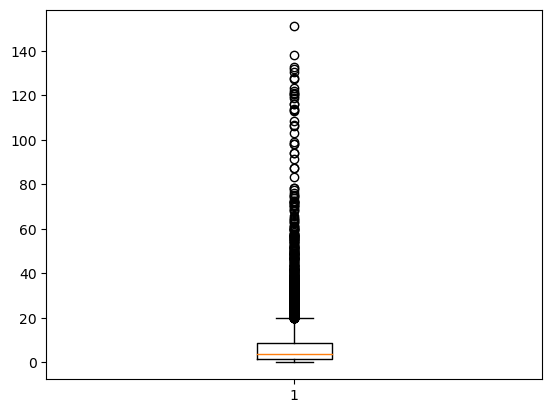

In [11]:
# boxplot
plt.boxplot(error_angle)

22.041366900069622


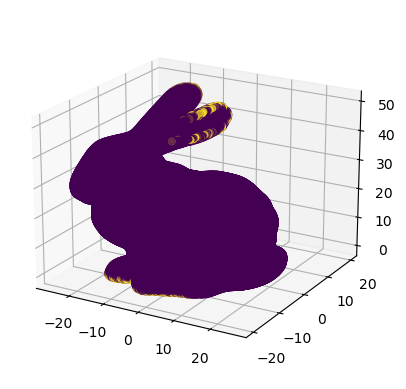

In [15]:
# dove sono le normali più problematiche:
perc = np.percentile(error_angle, 97.85)
print(perc)
idx = np.where(error_angle > perc)
colors = np.zeros(len(error_angle))
colors[idx] = 1.0

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(np.asarray(pcd.points)[:,0], np.asarray(pcd.points)[:,1], np.asarray(pcd.points)[:,2], c=colors)

ax.view_init(elev=20, azim=300)

In [17]:
# quando ho errore > 90, inverto direzione delle normali corrispondenti
est_normals = np.asarray(pcd.normals)
est_normals[idx] = - est_normals[idx]

pcd.normals = o3d.utility.Vector3dVector(est_normals)


In [ ]:
# costruisco mesh con normali "girate":
# -> vai a poisson reconstruction sotto

[]

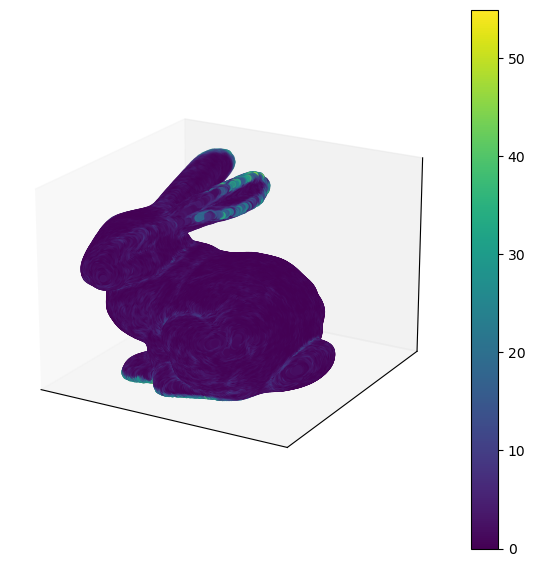

In [18]:
fig = plt.figure(figsize=(7,7))

ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(np.asarray(pcd.points)[:,0], np.asarray(pcd.points)[:,1], np.asarray(pcd.points)[:,2], c = error_angle)

fig.colorbar(scatter)

ax.view_init(elev=20, azim=300)
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

http://www.open3d.org/docs/release/tutorial/geometry/pointcloud.html

## Ball pivoting algorithm with estimated normals

### SPHERE (r = 3 dist) / BUNNY (r = 0.75 dist)

In [ ]:
distances = pcd.compute_nearest_neighbor_distance()
avg_dist = np.mean(distances)
#radius = 3 * avg_dist          # sphere
radius = 0.75 * avg_dist        # bunny

In [ ]:
bpa_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd,o3d.utility.DoubleVector([radius, radius * 2]))

In [ ]:
dec_mesh = bpa_mesh.simplify_quadric_decimation(100000)

In [ ]:
dec_mesh.remove_degenerate_triangles()
dec_mesh.remove_duplicated_triangles()
dec_mesh.remove_duplicated_vertices()
dec_mesh.remove_non_manifold_edges()

In [ ]:
o3d.io.write_triangle_mesh("bunny_norm_bpa_mesh.ply", dec_mesh)

In [ ]:
def lod_mesh_export(mesh, lods, extension):
    mesh_lods={}
    for i in lods:
        mesh_lod = mesh.simplify_quadric_decimation(i)
        o3d.io.write_triangle_mesh("bunny_norm_bpa_lod_"+str(i)+extension, mesh_lod)
        mesh_lods[i]=mesh_lod
    print("generation of "+str(i)+" LoD successful")
    return mesh_lods

In [ ]:
my_lods = lod_mesh_export(bpa_mesh, [100000,50000,10000,1000,100], ".ply")

In [ ]:
# DÀ PROBLEMI, EVITARE SE NON STRETTAMENTE NECESSARIO!
# for visualization

o3d.visualization.draw_geometries([my_lods[100000]])

Funziona bene con la sfera, con il coniglio taglia un orecchio

## Poisson reconstruction algorithm with estimated normals

In [12]:
poisson_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=8, width=0, scale=1.1, linear_fit=False)[0]
p_mesh_crop = poisson_mesh

In [14]:
# no
# bbox = pcd.get_axis_aligned_bounding_box()
# p_mesh_crop = poisson_mesh.crop(bbox)

In [13]:
p_mesh_crop.paint_uniform_color(np.array([[0.5],[0.5],[0.5]]))

TriangleMesh with 11908 points and 23792 triangles.

In [14]:
p_mesh_crop.compute_vertex_normals()
print(np.asarray(p_mesh_crop.triangle_normals))
o3d.visualization.draw_geometries([p_mesh_crop])

[[-0.4954914  -0.54001961 -0.68034336]
 [-0.05536631 -0.6046873  -0.79453624]
 [-0.05244362 -0.62084793 -0.78217487]
 ...
 [ 0.12691009  0.66026036 -0.74023651]
 [ 0.09198161  0.59795467 -0.79623463]
 [ 0.15534306  0.59321065 -0.7899175 ]]


In [ ]:
o3d.io.write_triangle_mesh("sphere_norm_poiss_mesh.ply", p_mesh_crop)

In [ ]:
# buco in un orecchio in alto, buco agli spigoli alla base ma ci sono anche con normali vere
# due buchi isolati nella sfera, ma ci sono anche con normali vere

## Errore mesh

In [ ]:
import trimesh

# Load the mesh from a PLY file
mesh = trimesh.load_mesh('sphere_norm_poiss_mesh.ply')

# Sample points
points = np.asarray(pcd.points)

# # Compute distances from points to the mesh surface
# distances = mesh.nearest.distance(points)

# # Print the distances
# for point, distance in zip(points, distances):
#     print(f"Point {point}: Distance = {distance}")

(closest_points,
 distances,
 triangle_id) = mesh.nearest.on_surface(points)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(np.asarray(pcd.points)[:,0], np.asarray(pcd.points)[:,1], np.asarray(pcd.points)[:,2], c = distances)

fig.colorbar(scatter)

ax.view_init(elev=20, azim=300)